<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY9143HPML/blob/main/Lab/Lab3/Lab3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read the two blogs, one by Andre Pernunicic and other by Daniel Godoy on weight initialization. You will reuse the code at github repo linked in the blog for explaining vanishing and exploding gradients. You can use the same 5 layer neural network model as in the repo and the same dataset.

1. Explain vanishing gradients phenomenon using standard normalization with different values of standard deviation and tanh and sigmoid activation functions. Then show how Xavier (aka Glorot normal) initialization of weights helps in dealing with this problem. Next use ReLU activation and show that instead of Xavier initialization, He initialization works better for ReLU activation. You can plot activations at each of the 5 layers to answer this question. (8)

2. The dying ReLU is a kind of vanishing gradient, which refers to a problem when ReLU neurons become inactive and only output 0 for any input. In the worst case of dying ReLU, ReLU neurons at a certain layer are all dead, i.e., the entire network dies and is referred to as the dying ReLU neural networks in Lu et al (reference below). A dying ReLU neural network collapses to a constant function. Show this phenomenon using any one of the three 1-dimensional functions on page 13 of Lu et al. Use a 10-layer ReLU network with width 2 (hidden units per layer). Use minibatch of 64 and draw training data uniformly from $[\sqrt{-7}, \sqrt{7}]$. Perform 1000 independent training simulations each with 3,000 training points. Out of these 1000 simulations, what fraction resulted in neural network collapse. Is your answer close to over 90% as was reported in Lu et al. ? (8)

3. Instead of ReLU consider Leaky ReLU activation as defined below:
$$
\begin{gathered}
\phi(z) = 
\begin{cases}
z & \text{if  } z>0\\
0.01z & \text{if  } z\le 0
\end{cases}
\end{gathered}
$$

Run the 1000 training simulations in part 2 with Leaky ReLU activation and keep everything else the same. Again calculate the fraction of simulations that resulted in neural network collapse. Did Leaky ReLU help in preventing dying neurons? (4)

*Reference*

* Andre Perunicic. Understand neural network weight initialization. Available at https://intoli.com/blog/neural-network-initialization/ 
* Daniel Godoy. Hyper-parameters in Action Part II — Weight Initializers.
* Initializers - Keras documentation. https://keras.io/initializers/.
* Lu Lu et al. Dying ReLU and Initialization: Theory and Numerical Examples.

## Problem 1

Explain vanishing gradients phenomenon using standard normalization with different values of standard deviation and tanh and sigmoid activation functions. Then show how Xavier (aka Glorot normal) initialization of weights helps in dealing with this problem. Next use ReLU activation and show that instead of Xavier initialization, He initialization works better for ReLU activation. You can plot activations at each of the 5 layers to answer this question. (8)

In [1]:
!pip install tensorboard==2.3.0
!pip install tensorboard-plugin-wit==1.7.0
!pip install tensorflow-estimator==2.3.0
!pip install tensorflow-gpu==2.3.0
!pip install tensorflow-gpu-estimator==2.3.0
!pip install keras==2.4.3
!pip install keras-preprocessing==1.1.2

     |████████████████████████████████| 6.8 MB 5.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.3.0 which is incompatible.
     |████████████████████████████████| 779 kB 4.0 MB/s 
  Attempting uninstall: tensorboard-plugin-wit
    Found existing installation: tensorboard-plugin-wit 1.8.1
    Uninstalling tensorboard-plugin-wit-1.8.1:
      Successfully uninstalled tensorboard-plugin-wit-1.8.1
     |████████████████████████████████| 459 kB 5.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing instal

     |████████████████████████████████| 474 kB 5.2 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.4.3 which is incompatible.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
tensorflow 2.8.0 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.3.0 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras import backend as K
from keras import initializers
# from keras.optimizers import rmsprop_v2
from tensorflow.keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.utils import np_utils
from matplotlib import pyplot as plt
from matplotlib import rcParamsDefault

In [4]:
def grid_axes_it(n_plots, n_cols = 3, enumerate = False, fig = None):
  '''
  Iterate through Axes objects on a grid with n_cols columns and as many rows as needed to accommodate n_plots many plots.
  We will get n_plots many Axes objects on a grid
  :param n_plots: number of plots to plot onto figure
  :param n_cols: number of columns to divide the figure into
  :param fig: optional figure reference
  
  '''
  n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

  if not fig:
    default_figsize = rcParamsDefault['figure.figsize']
    fig = plt.figure(figsize = (
        default_figsize[0] * n_cols,
        default_figsize[1] * n_rows
    ))
  
  for i in range(1, n_plots + 1):
    ax = plt.subplot(n_rows, n_cols, i)
    yield ax

Create MLP model

In [5]:
def create_mlp_model(n_hidden_layers, dim_layer, input_shape, n_classes, kernel_initializer, bias_initializer, activation):
  '''
  create mlp with given parameters
  '''
  model = Sequential()
  model.add(Dense(dim_layer, input_shape = input_shape, kernel_initializer = kernel_initializer, bias_initializer = bias_initializer))
  for i in range(n_hidden_layers):
    model.add(Dense(dim_layer, activation = activation, kernel_initializer = kernel_initializer, bias_initializer = bias_initializer))
  model.add(Dense(n_classes, activation = 'softmax', kernel_initializer = kernel_initializer, bias_initializer = bias_initializer))
  return model

In [6]:
def create_cnn_model(input_shape, num_classes, kernel_initializer = 'glorot_uniform', bias_initializer = 'zeros'):
  model = Sequential()
  model.add(Conv2D(32, kernel_size = (3, 3),
                   activation = 'relu',
                   input_shape = input_shape,
                   kernel_initializer = kernel_initializer,
                   bias_initializer = bias_initializer))
  model.add(Conv2D(64, (3, 3), activation = 'relu',
                   kernel_initializer = kernel_initializer,
                   bias_initializer = bias_initializer))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation = 'relu',
                  kernel_initializer = kernel_initializer,
                  bias_initializer = bias_initializer))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax',
                  kernel_initializer = kernel_initializer,
                  bias_initializer = bias_initializer))
  return model

In [7]:
def compile_model(model):
  model.compile(loss = keras.losses.categorical_crossentropy, optimizer = 'rmsprop', metrics = ['accuracy'])
  return model

In [8]:
def get_init_id(init):
  '''
  :param init: Instance of some initializer frrom keras.initializers
  returns string ID summarizing initialization scheme and its parameters
  '''
  try:
    init_name = str(init).split('.')[2].split(' ')[0]
  except:
    init_name = str(init).split(' ')[0].replace('.', '_')

  param_list = []
  config = init.get_config()
  for k, v in config.items():
    if k == 'seed':
      continue
    param_list.append('{k}--{v}'.format(k = k, v = v))
  init_params = '__'.join(param_list)

  return '|'.join([init_name, init_params])

In [9]:
def get_activations(model, x, mode = 0.0):
  '''
  extract activations with given model and input vector x
  '''
  outputs = [layer.output for layer in model.layers]
  activations = K.function(model.input, outputs)
  output_elts = activations([x, mode])
  return output_elts

In [10]:
class LossHistory(keras.callbacks.Callback):
    '''
    A custom keras callback for recording losses during network training.
    '''

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))

In [11]:
seed = 10

# Number of points to plot
n_train = 1000
n_test = 100
n_classes = 10

# Network params
n_hidden_layers = 5
dim_layer = 100
batch_size = n_train
epochs = 1

In [12]:
# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000
(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

11493376/11490434 [==============================] - 0s 0us/step


In [13]:
x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

In [14]:
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [15]:
rows = []
sigmas = [0.10, 0.14, 0.28]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'tanh'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

In [16]:
df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

In [17]:
df

,Hidden Layer,Standard Deviation,Output
0,1,0.10,0.967427
1,1,0.10,0.708782
2,1,0.10,-0.077793
3,1,0.10,-0.044652
4,1,0.10,-0.964942
...,...,...,...
749995,5,0.28,0.956301
749996,5,0.28,-0.997355
749997,5,0.28,0.991971
749998,5,0.28,0.232120


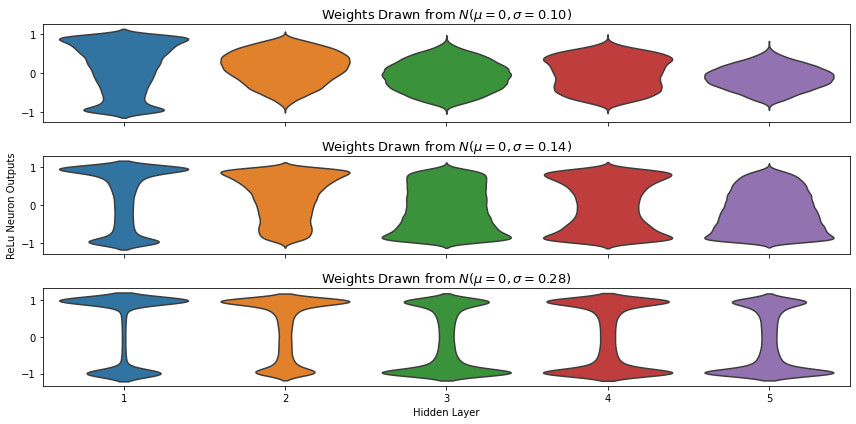

In [18]:
# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()